# Demonstrate scaling property of brownian reservoir

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from record_0_main import smlt_ma, smlt_lnma
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

params_0 = {'TAU_R': tau_r, 'TAU_A': tau_a, 'X_S': x_s, 'X_P': x_p}
params_1 = {'TAU_R': np.random.uniform(20, 120, N), 'TAU_A': tau_a, 'X_S': x_s, 'X_P': x_p}

In [5]:
# get snippets
T_SNP = 320  # min snippet length to fetch
NT_SNP = int(round(T_SNP*FPS))

snps = []

sys.stdout.write(f'T_SNP {T_SNP}: ')

t_snp = np.arange(NT_SNP)*DT

for csng, sng_full in enumerate(sngs_full):

    segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
    segs = [sng_full[lb:ub] for lb, ub in bds if (ub-lb >= NT_SNP)]
    snps.extend(segs)

nsnp = len(snps)

sys.stdout.write(f'{nsnp} snippets\n')

print('Lengths:')
print([f'{len(snp)*DT:.2f}' for snp in snps])

T_SNP 320: 54 snippets
Lengths:
['324.21', '376.89', '370.40', '375.46', '574.59', '1602.16', '443.79', '607.13', '733.97', '1786.58', '322.48', '420.28', '1514.05', '505.83', '1732.73', '575.29', '609.92', '542.29', '348.65', '1771.50', '340.16', '881.42', '338.99', '463.17', '1038.26', '1772.66', '734.37', '402.26', '374.36', '858.18', '705.89', '502.50', '903.50', '748.45', '1773.49', '546.92', '372.23', '589.31', '496.04', '1076.49', '1259.11', '447.89', '602.60', '434.20', '1318.58', '613.42', '677.99', '1795.74', '355.48', '931.10', '468.63', '1793.67', '468.27', '1003.20']


In [6]:
rs_ma_all_0 = []
rs_lnma_all_0 = []

rs_ma_all_1 = []
rs_lnma_all_1 = []

for snp in snps:
    sys.stdout.write('.')

    i_s = (snp == 1).astype(float)
    i_p = (snp == 2).astype(float)

    t_snp = np.arange(len(snp))*DT

    rs_ma_0 = smlt_ma(i_s, i_p, params_0, DT)
    rs_ma_all_0.append(rs_ma_0)
    
    rs_lnma_0 = smlt_lnma(i_s, i_p, params_0, DT)
    rs_lnma_all_0.append(rs_lnma_0)
    
    rs_ma_1 = smlt_ma(i_s, i_p, params_1, DT)
    rs_ma_all_1.append(rs_ma_1)
    
    rs_lnma_1 = smlt_lnma(i_s, i_p, params_1, DT)
    rs_lnma_all_1.append(rs_lnma_1)

......................................................

## Stats -- scaling

In [7]:
ALPHA = 1e-15
T_YS = [1.25, 2.5, 5, 10, 20, 40, 80, 160, 320, 640, 1280, 2560]  # song duration and sine wave half period

err_mas_0 = np.nan*np.zeros((len(T_YS), len(snps)))
err_lnmas_0 = np.nan*np.zeros((len(T_YS), len(snps)))

err_mas_1 = np.nan*np.zeros((len(T_YS), len(snps)))
err_lnmas_1 = np.nan*np.zeros((len(T_YS), len(snps)))

for cy, T_Y in enumerate(T_YS):

    # get snps longer than T_Y
    isnps = np.nonzero([len(snp) >= (T_Y/2*FPS) for snp in snps])[0]

    for isnp in isnps:
        snp = snps[isnp]
        
        t = np.arange(len(snp))*DT
        mt = (t <= (T_Y/2))  # mask
        y = np.sin(2*np.pi*t[mt]/T_Y)
        
        rs_ma_0 = rs_ma_all_0[isnp]
        rs_lnma_0 = rs_lnma_all_0[isnp]
        
        # fit MA model
        y_hat = linear_model.Ridge(alpha=ALPHA).fit(rs_ma_0[mt, :], y).predict(rs_ma_0[mt, :])
        err_mas_0[cy, isnp] = np.sqrt(np.mean((y-y_hat)**2))

        # fit LNMA model
        y_hat = linear_model.Ridge(alpha=ALPHA).fit(rs_lnma_0[mt, :], y).predict(rs_lnma_0[mt, :])
        err_lnmas_0[cy, isnp] = np.sqrt(np.mean((y-y_hat)**2))
        
        # heterogeneous tau_r pop
        rs_ma_1 = rs_ma_all_1[isnp]
        rs_lnma_1 = rs_lnma_all_1[isnp]
        
        # fit MA model
        y_hat = linear_model.Ridge(alpha=ALPHA).fit(rs_ma_1[mt, :], y).predict(rs_ma_1[mt, :])
        err_mas_1[cy, isnp] = np.sqrt(np.mean((y-y_hat)**2))

        # fit LNMA model
        y_hat = linear_model.Ridge(alpha=ALPHA).fit(rs_lnma_1[mt, :], y).predict(rs_lnma_1[mt, :])
        err_lnmas_1[cy, isnp] = np.sqrt(np.mean((y-y_hat)**2))

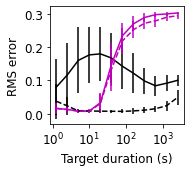

In [16]:

fig, ax = plt.subplots(1, 1, figsize=(2.75, 2.5), tight_layout=True)
ax.errorbar(T_YS, np.nanmean(err_mas_0, 1), yerr=np.nanstd(err_mas_0, 1), c='k')
ax.errorbar(T_YS, np.nanmean(err_lnmas_0, 1), yerr=np.nanstd(err_lnmas_0, 1), c='m')

ax.errorbar(T_YS, np.nanmean(err_mas_1, 1), yerr=np.nanstd(err_mas_1, 1), c='k', ls='--')
ax.errorbar(T_YS, np.nanmean(err_lnmas_1, 1), yerr=np.nanstd(err_lnmas_1, 1), c='m', ls='--')

ax.set_xscale('log')
set_plot(ax, x_ticks=[1, 10, 100, 1000], x_label='Target duration (s)', y_label='RMS error')

fig.savefig('ms/4_res_comp_ma_vs_ln_scaling_het_tau_r.svg')